## **Denoising with a Convolutional Autoencoder**

**Imports**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display
from google.colab import drive
import os

**Parameters**

In [2]:
epochs = 15
batch_size = 128
device = "cuda"

**Load and Preprocess the MNIST Dataset**

In [3]:
def preprocessing(image):
  # Add noise to images
  noise_factor = 0.5
  image_noisy = noise_factor * torch.randn(image.shape) + image
  image_noisy = torch.clamp(image_noisy, 0, 1)

  return image_noisy, image

In [4]:
torch.manual_seed(123) #for dataset reproducibility

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: preprocessing(x))
])

train_dataset = DataLoader(
    MNIST("/content/", train=True, transform=transform, download=True),
    batch_size=batch_size,
    shuffle=True
)

test_dataset = DataLoader(
    MNIST("/content/", train=False, transform=transform, download=True),
    batch_size=batch_size,
    shuffle=False
)

In [5]:
for (im, im2), _ in train_dataset:
  print(im.shape)
  break

torch.Size([128, 1, 28, 28])


In [6]:
im.min(), im.max()

(tensor(0.), tensor(1.))

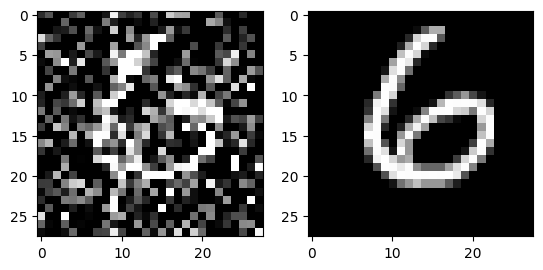

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im[0].permute(1, 2, 0), cmap="gray")
ax[1].imshow(im2[0].permute(1, 2, 0), cmap="gray");

**Build the Model**

In [8]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder
    self.encoder_model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1), # Bottleneck
        nn.ReLU()
    )

    # Bottleneck visualization
    self.encoder_visualization = nn.Sequential(
        nn.Conv2d(256, 1, kernel_size=(3, 3), padding=1),
        nn.Sigmoid()
    )

    # Decoder
    self.decoder_model = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=(2, 2)),
        nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=(2, 2)),
        nn.Conv2d(64, 1, kernel_size=(3, 3), padding=1),
        nn.Sigmoid() #Pixel values vary from 0 (black) to 1 (white)
    )

  def forward(self, x):
    x = self.encoder_model(x)
    x = self.decoder_model(x)
    return x

  def encoder(self, x):
    x = self.encoder_model(x)
    x = self.encoder_visualization(x)
    return x

In [9]:
torch.manual_seed(123)

autoencoder_model = Autoencoder().to(device)

# Autoencoder architecture
summary(autoencoder_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
              ReLU-5          [-1, 128, 14, 14]               0
         MaxPool2d-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 7, 7]         295,168
              ReLU-8            [-1, 256, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]         295,040
             ReLU-10            [-1, 128, 7, 7]               0
         Upsample-11          [-1, 128, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          73,792
             ReLU-13           [-1, 64, 14, 14]               0
         Upsample-14           [-1, 64,

**Train the Model**

In [10]:
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [11]:
def train_autoencoder(epochs=epochs):
  history = {"loss":[], "val_loss":[]}

  for epoch in range(epochs):
    loss_list, val_loss_list = [], []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch {epoch+1}/{epochs}]")
      for (images_noisy, images), _ in pbar:
        images_noisy = images_noisy.to(device)
        images = images.to(device)

        # Update Autoencoder
        optimizer.zero_grad()
        gen_images = autoencoder_model(images_noisy)
        loss = criterion(gen_images, images)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

    loss_mean = np.mean(loss_list)
    history["loss"].append(loss_mean)

    # Calculate test_dataset loss
    with torch.no_grad():
      for (images_test_noisy, images_test), _ in test_dataset:
        images_test_noisy = images_test_noisy.to(device)
        images_test = images_test.to(device)

        gen_images_test = autoencoder_model(images_test_noisy)
        val_loss = criterion(gen_images_test, images_test)
        val_loss_list.append(val_loss.item())

    val_loss_mean = np.mean(val_loss_list)
    history["val_loss"].append(val_loss_mean)

    # Clean pbar description and postfix
    display.clear_output(wait=True)
    for i in range(epoch+1):
      print(f"[Epoch {i+1:>{len(str(epochs))}}/{epochs}]:   loss: {history['loss'][i]:.4f} - val_loss: {history['val_loss'][i]:.4f}")

  return history

In [12]:
history = train_autoencoder()

[Epoch  1/15]:   loss: 0.1530 - val_loss: 0.1046
[Epoch  2/15]:   loss: 0.1019 - val_loss: 0.0988
[Epoch  3/15]:   loss: 0.0985 - val_loss: 0.0963
[Epoch  4/15]:   loss: 0.0966 - val_loss: 0.0949
[Epoch  5/15]:   loss: 0.0953 - val_loss: 0.0939
[Epoch  6/15]:   loss: 0.0945 - val_loss: 0.0932
[Epoch  7/15]:   loss: 0.0936 - val_loss: 0.0927
[Epoch  8/15]:   loss: 0.0931 - val_loss: 0.0919
[Epoch  9/15]:   loss: 0.0926 - val_loss: 0.0917
[Epoch 10/15]:   loss: 0.0922 - val_loss: 0.0915
[Epoch 11/15]:   loss: 0.0918 - val_loss: 0.0909
[Epoch 12/15]:   loss: 0.0915 - val_loss: 0.0907
[Epoch 13/15]:   loss: 0.0911 - val_loss: 0.0906
[Epoch 14/15]:   loss: 0.0909 - val_loss: 0.0904
[Epoch 15/15]:   loss: 0.0908 - val_loss: 0.0901


In [13]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs=epochs):
  losses = history["loss"]
  val_losses = history["val_loss"]
  list_epochs = np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name="Val Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"Evolution of Loss across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [14]:
# Interactive graphic
plot_metrics(history)

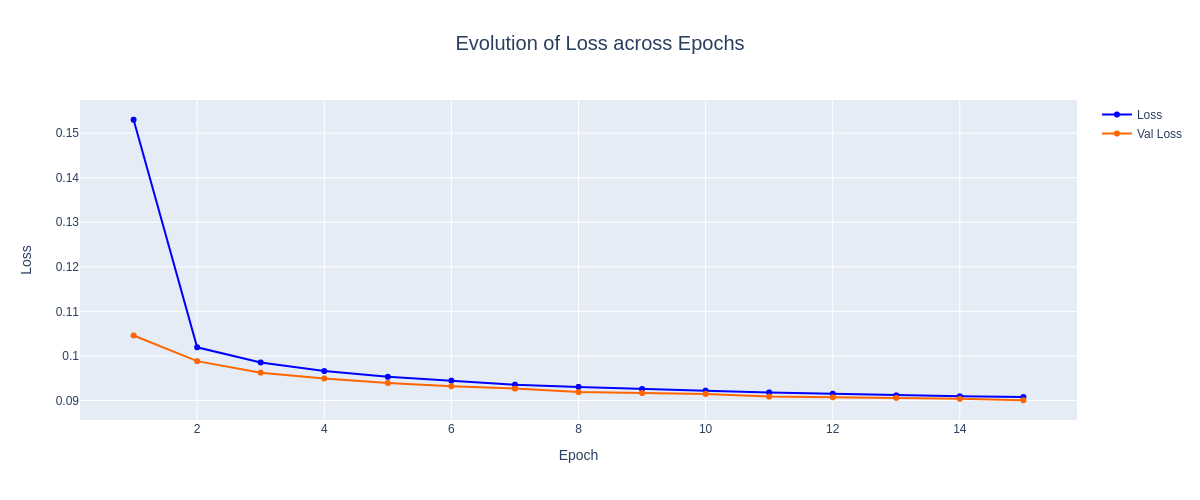

In [15]:
# Image for GitHub
plot_metrics(history, renderer="png")

There is no overfitting observed.

**Test set results**

In [16]:
# Take a batch of test_dataset
for (images_noisy, images), _ in test_dataset:
  break

images_noisy.shape

torch.Size([128, 1, 28, 28])

In [17]:
# Predictions
images_noisy = images_noisy.to(device)

latent_rep = autoencoder_model.encoder(images_noisy).detach().cpu()
gen_images = autoencoder_model(images_noisy).detach().cpu()
images_noisy = images_noisy.cpu()

latent_rep.shape, gen_images.shape

(torch.Size([128, 1, 7, 7]), torch.Size([128, 1, 28, 28]))

In [18]:
names = ["Noisy Images", "Latent Representation", "Generated Images"]

In [20]:
# Create the images folder
drive.mount("/content/drive")

directory_images = "/content/drive/MyDrive/images/autoencoder"
os.makedirs(directory_images, exist_ok=True)

Mounted at /content/drive


In [21]:
# Function to display images

def show_images(images_noisy, latent_rep, gen_images, save=False, num_examples=5, names=names, random=True, cmap="gray"):

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(num_examples, 3, figsize=(6, num_examples*2))

  for i in range(num_examples):
    ax[i, 0].imshow(images_noisy[indices[i]].permute(1, 2, 0), cmap="gray")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(latent_rep[indices[i]].permute(1, 2, 0), cmap="gray")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(gen_images[indices[i]].permute(1, 2, 0), cmap="gray")
    ax[i, 2].axis("off")

  ax[0, 0].set_title(names[0], fontsize=8, fontweight="bold")
  ax[0, 1].set_title(names[1], fontsize=8, fontweight="bold")
  ax[0, 2].set_title(names[2], fontsize=8, fontweight="bold")

  if save:
    plt.savefig(os.path.join(directory_images, "ConvAutoencoder_Denoising_MNIST.png"),
                transparent=True)

  plt.show()

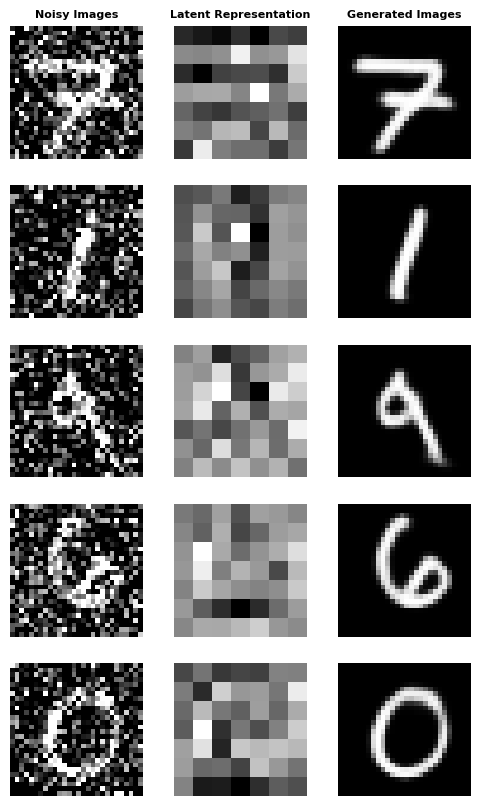

In [51]:
# Save an image with some examples
show_images(images_noisy, latent_rep, gen_images, save=True, num_examples=5)

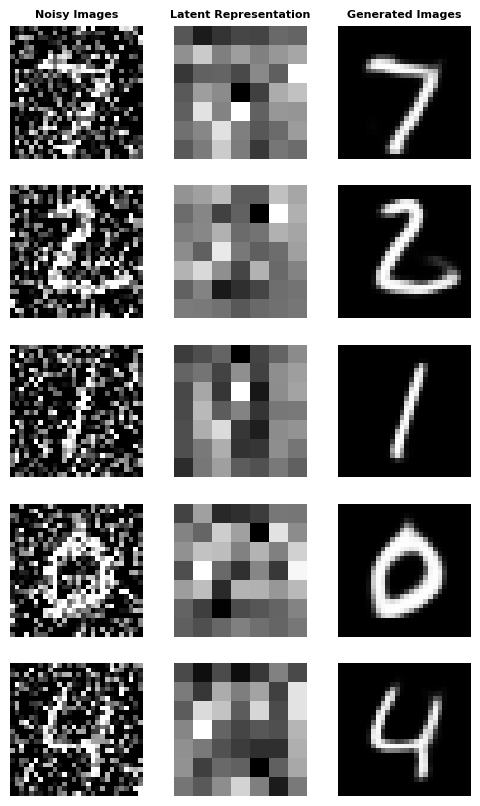

In [23]:
show_images(images_noisy, latent_rep, gen_images, random=False, num_examples=5)

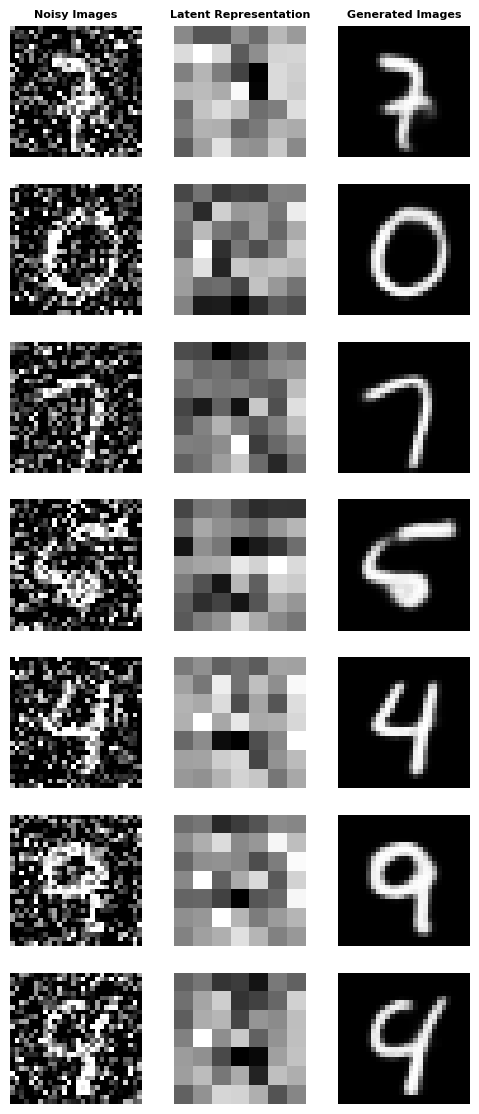

In [24]:
show_images(images_noisy, latent_rep, gen_images, num_examples=7)